# Simple feed forward NN to predict IC50 based on patient demographic and molecular drug information (BASELINE MODEL)

In [32]:
from CHEM277B_functions import *

In [33]:
valid_IC50s = pd.read_csv("data/valid_IC50s_within_range.csv")
merged_df = pd.read_csv("data/final_merged.csv")
lucas_df = pd.read_csv("data/final_mapping.csv")
cell_lines_df = pd.read_csv("data/HarvardCellLines.csv")

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_14517/2977721343.py:2: DtypeWarning: Columns (0,3,4,5,6,7,9,12,15,16,17,18,22,24,26,28,29,30,40,65,66,67,68,69,70,71,72,73,74,75,76,82,83,89,90,91,92,93,96,97,98,99,100,101,102,103,104,105,106,107,108,109,115) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("final_merged.csv")


In [34]:
valid_IC50s.drop(columns = ['Unnamed: 0', 'N Points'], inplace = True)

In [35]:
columns = ["HMS LINCS ID", "Name", "T Stage"]
cell_lines_df = cell_lines_df[columns]

In [36]:
merged_df["Race"].value_counts()

Race
1.0    5857
2.0     470
4.0     321
0.0      19
5.0      18
3.0      14
6.0       9
8.0       4
7.0       1
Name: count, dtype: int64

In [37]:
# TEMPORARY IMPUTATION OF RACE BASED OFF PROPORTIONS OF EXISTING RACES.
# WILL USE AUSTIN'S IMPUTED RACE ANALYSIS LATER.

# Get value counts as probabilities
race_dist = merged_df['Race'].value_counts(normalize=True)

# Get the indices where race is missing
missing_indices = merged_df['Race'].isna()

# Sample values based on observed distribution
imputed_values = np.random.choice(race_dist.index, size=missing_indices.sum(), p=race_dist.values)

# Assign the sampled values to the missing positions
merged_df.loc[missing_indices, 'Race'] = imputed_values

In [38]:
merged_df['T_stage_by_size'] = merged_df.apply(lambda row: row['T Stage'] if pd.notnull(row['T Stage']) else T_stage_by_size(row['Tumor Size']), axis=1)

In [39]:
columns = ['Age', 'Race', 'T_stage_by_size']
patients_df = merged_df[columns]

In [40]:
def get_biased_cell_lines(patient_row, cell_line_df, n=3):
    # Filter for matching T_stage
    filtered = cell_line_df[cell_line_df["T Stage"] == patient_row["T_stage_by_size"]]

    # If fewer than n matches, fall back to all cell lines
    if len(filtered) < n:
        filtered = cell_line_df

    return np.random.choice(filtered["HMS LINCS ID"], size=n, replace=False).tolist()

In [41]:
patients_df["T_stage_by_size"].apply(type).value_counts()

T_stage_by_size
<class 'float'>    9222
Name: count, dtype: int64

In [42]:
cell_lines_df["T Stage"].apply(type).value_counts()

T Stage
<class 'float'>    35
Name: count, dtype: int64

In [43]:
# Add a list of 3 biased cell lines per patient
patients_df["cell_lines"] = patients_df.apply(lambda row: get_biased_cell_lines(row, cell_lines_df), axis=1)


/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_14517/1392642400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df["cell_lines"] = patients_df.apply(lambda row: get_biased_cell_lines(row, cell_lines_df), axis=1)


In [44]:
patients_df

,Age,Race,T_stage_by_size,cell_lines
0,41,2.0,2.0,"[50205, 50216, 50211]"
1,41,2.0,2.0,"[50579, 50211, 50205]"
2,38,2.0,2.0,"[50211, 50212, 50205]"
3,62,1.0,2.0,"[50216, 50213, 50205]"
4,62,1.0,2.0,"[50205, 50579, 50211]"
...,...,...,...,...
9217,69,1.0,4.0,"[50335, 51083, 50057]"
9218,69,1.0,4.0,"[50331, 50105, 51081]"
9219,69,1.0,4.0,"[50327, 50331, 50334]"
9220,69,1.0,4.0,"[50008, 50328, 50335]"


In [45]:
# Explode so each row = 1 (patient, cell_line)
patients_df = patients_df.explode("cell_lines").reset_index(drop=True)

In [46]:
cell_lines_df_dict = cell_lines_df.set_index("HMS LINCS ID").to_dict()["Name"]

In [47]:
patients_df["Cell Name"] = patients_df["cell_lines"].apply(mapping, dictionary = cell_lines_df_dict)

In [48]:
patients_df

,Age,Race,T_stage_by_size,cell_lines,Cell Name
0,41,2.0,2.0,50205,HCC1143
1,41,2.0,2.0,50216,HCC38
2,41,2.0,2.0,50211,HCC1806
3,41,2.0,2.0,50579,HCC1500
4,41,2.0,2.0,50211,HCC1806
...,...,...,...,...,...
27661,69,1.0,4.0,50328,MDA-MB-157
27662,69,1.0,4.0,50335,MDA-MB-468
27663,69,1.0,4.0,50238,Hs 578T
27664,69,1.0,4.0,50029,MCF7


In [49]:
patients_df.dropna(inplace=True)
patients_df.isna().sum()

Age                0
Race               0
T_stage_by_size    0
cell_lines         0
Cell Name          0
dtype: int64

# Add Small Molecule descriptors for each row. 

In [51]:
drugs_df = pd.read_csv("Descriptors_Small_Molecules.csv")
drugs_df = drugs_df[['Name', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
drugs_df.rename(columns={'Name': 'Small Molecule Name'}, inplace=True)
drugs_df.head()

,Small Molecule Name,Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA
0,AZD7762,362.12,2.52660,4,4,96.25
1,Neratinib,556.20,5.93248,2,8,112.40
2,Dasatinib,487.16,3.31354,3,9,106.51
3,Saracatinib,541.21,3.93950,1,10,90.44
4,Pictilisib,513.16,2.14840,1,9,107.55


In [52]:
valid_IC50s.columns

Index(['Cell Name', 'Small Molecule Name', 'EC50 (uM)'], dtype='object')

In [53]:
valid_IC50s = pd.merge(valid_IC50s, drugs_df, on='Small Molecule Name', how='left')

In [54]:
patient_drug_df = pd.merge(patients_df, valid_IC50s, on='Cell Name', how='left')

In [55]:
patient_drug_df.drop(columns = "cell_lines", inplace=True)

In [56]:
patient_drug_df.to_csv("patient_drug_information_aka_final_final_final.csv")

In [57]:
race_dict = {0:'N/A', 1:"white", 2:"black", 3:"asian", 4:"native", 5:"hispanic", 6:"multi", 7:"hawa", 8:"amer indian"}

In [58]:
patient_drug_df["Race"] = patient_drug_df["Race"].apply(mapping, dictionary = race_dict)

### Cell lines are proxy for patients, so drop the cell lines column. 

In [60]:
patient_drug_df.drop(columns="Cell Name", inplace=True)

### Need to one-hot-encode categorical featurs

In [62]:
categorical_cols = ['Race', 'T_stage_by_size', 'Small Molecule Name']
patient_drug_df[categorical_cols] = patient_drug_df[categorical_cols].astype('category')

In [63]:
patient_drug_df_encoded = pd.get_dummies(patient_drug_df, columns=categorical_cols, drop_first=True)
print(patient_drug_df_encoded.dtypes)

Age                                   int64
EC50 (uM)                           float64
Molecular Mass                      float64
LogP                                float64
NumHDonors                            int64
NumHAcceptors                         int64
TPSA                                float64
Race_amer indian                       bool
Race_asian                             bool
Race_black                             bool
Race_hawa                              bool
Race_hispanic                          bool
Race_multi                             bool
Race_native                            bool
Race_white                             bool
T_stage_by_size_1.0                    bool
T_stage_by_size_2.0                    bool
T_stage_by_size_3.0                    bool
T_stage_by_size_4.0                    bool
Small Molecule Name_ABT-737            bool
Small Molecule Name_AZD7762            bool
Small Molecule Name_Abemaciclib        bool
Small Molecule Name_Alpelisib   

In [64]:
bool_cols = patient_drug_df_encoded.select_dtypes(include='bool').columns
patient_drug_df_encoded[bool_cols] = patient_drug_df_encoded[bool_cols].astype(int)

### PRE-PROCESSING DONE. ONTO MODEL TRAINING.

In [66]:
# Separate features (X) and target (y)
X = patient_drug_df_encoded.drop(columns=['EC50 (uM)'])  # Drop EC50 and non-features
y = patient_drug_df_encoded['EC50 (uM)']  # EC50 is the target

# Standardize numerical features
scaler = StandardScaler()
X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']] = scaler.fit_transform(X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]) 

In [67]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Data
# Select drug descriptor columns
drug_feature_cols = ['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
drug_features = X_train[drug_feature_cols].to_numpy()  # (n_samples, 5)

# Drop drug features to get patient features
patient_features = X_train.drop(columns=drug_feature_cols).to_numpy()

# Convert to tensors
drug_tensor = torch.tensor(drug_features).float()
patient_tensor = torch.tensor(patient_features).float()
ic50_tensor = torch.tensor(y_train.to_numpy()).float()

model = DrugResponsePredictor(drug_input_dim=5, patient_input_dim=patient_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


# Training loop
model.train()
start_time = time.time()

my_epochs = []
my_losses = []

for epoch in range(300):  # increase epochs for real training
    optimizer.zero_grad()
    preds = model(drug_tensor, patient_tensor)
    loss = loss_fn(preds, ic50_tensor)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    print(f"Time elapsed: {elapsed:.2f} seconds")
    my_epochs.append(epoch)
    my_losses.append(loss.item())

Epoch 0 | Loss: 4.5900
Time elapsed: 0.17 seconds
Epoch 1 | Loss: 4.5277
Time elapsed: 0.27 seconds
Epoch 2 | Loss: 4.4675
Time elapsed: 0.37 seconds
Epoch 3 | Loss: 4.4096
Time elapsed: 0.47 seconds
Epoch 4 | Loss: 4.3538
Time elapsed: 0.58 seconds
Epoch 5 | Loss: 4.3000
Time elapsed: 0.68 seconds
Epoch 6 | Loss: 4.2479
Time elapsed: 0.78 seconds
Epoch 7 | Loss: 4.1972
Time elapsed: 0.88 seconds
Epoch 8 | Loss: 4.1466
Time elapsed: 0.99 seconds
Epoch 9 | Loss: 4.0955
Time elapsed: 1.10 seconds
Epoch 10 | Loss: 4.0437
Time elapsed: 1.23 seconds
Epoch 11 | Loss: 3.9912
Time elapsed: 1.34 seconds
Epoch 12 | Loss: 3.9380
Time elapsed: 1.45 seconds
Epoch 13 | Loss: 3.8838
Time elapsed: 1.55 seconds
Epoch 14 | Loss: 3.8289
Time elapsed: 1.65 seconds
Epoch 15 | Loss: 3.7727
Time elapsed: 1.75 seconds
Epoch 16 | Loss: 3.7156
Time elapsed: 1.85 seconds
Epoch 17 | Loss: 3.6581
Time elapsed: 1.95 seconds
Epoch 18 | Loss: 3.5994
Time elapsed: 2.05 seconds
Epoch 19 | Loss: 3.5407
Time elapsed: 2.1

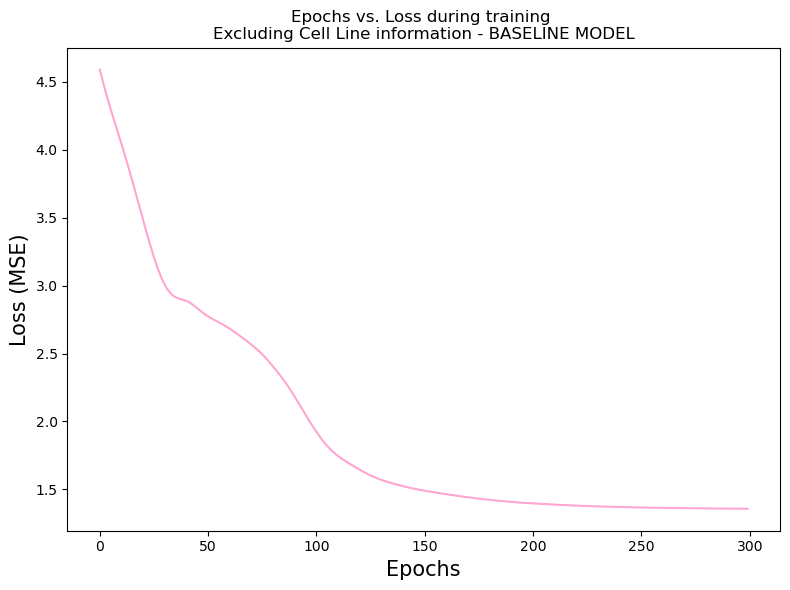

In [69]:
epochs_vs_loss_baseline(my_epochs, my_losses)

In [70]:
drug_features_test = X_test[['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
patient_features_test = X_test.drop(columns=drug_features_test.columns)

metrics = evaluate_model(model, drug_features_test, patient_features_test, y_test)

print(f"MSE: {metrics[0]:.4f}")
print(f"MAE: {metrics[1]:.4f}")
print(f"R²: {metrics[2]:.4f}")


MSE: 1.3475
MAE: 0.5955
R²: 0.5657


/Users/joyceyu/Documents/CHEM277B - ML Algorithms/Final project/Data_277_-Cancer/CHEM277B_functions.py:176: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal', color = "Black")


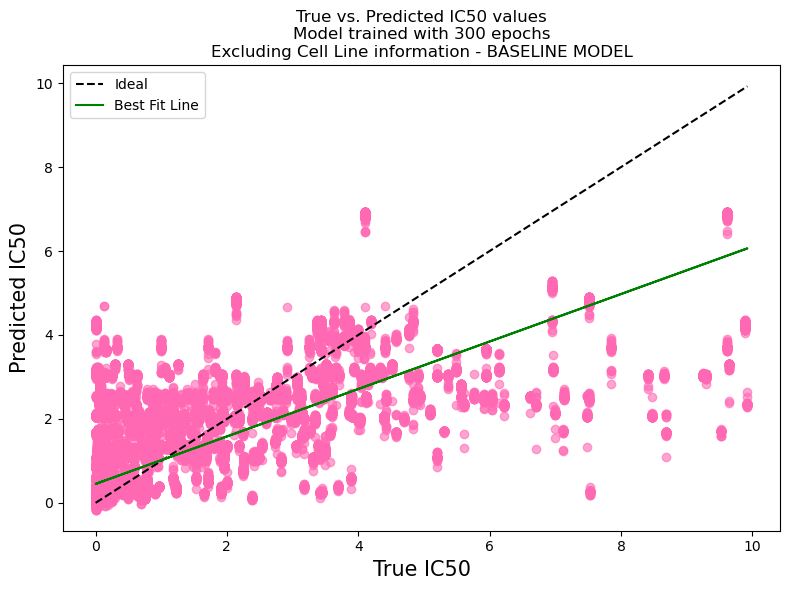

In [71]:
with torch.no_grad():
    preds = model(torch.tensor(drug_features_test.values).float(),
                  torch.tensor(patient_features_test.values).float()).cpu().numpy()
plot_pred_vs_true_baseline(y_test.to_numpy(), preds)

In [72]:
k_fold_cv = compute_CV_error(X_train,y_train)

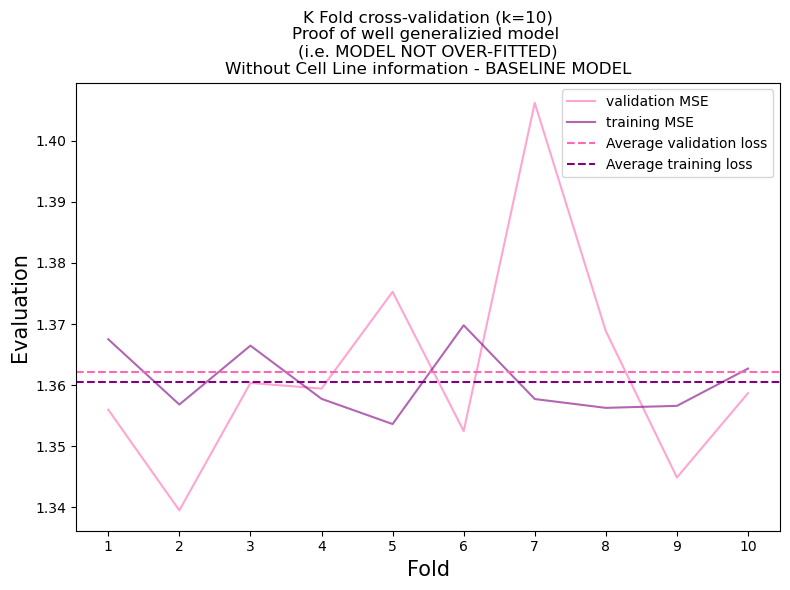

In [74]:
Kfold_CV_plot_baseline(k_fold_cv)